In [34]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj
import psutil
import os
import gc
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 10000  # Total de eventos a serem processados
chunk_size = 500   # Eventos por chunk

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file1 = '/home/levi/Documentos/Sinal_background/pp_zz_background_nobornQCD.hepmc'
background_file2 = '/home/levi/Documentos/Sinal_background/background_pp_jjmumu.hepmc'

# Função para ler eventos HEPMC em chunks
def read_hepmc_file_in_chunks(hepmc_file, max_events=max_events, chunk_size=chunk_size):
    events = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            events.append(event)
            if (i + 1) % chunk_size == 0:  # Processar chunk
                yield events
                events = []  # Limpar lista de eventos
                print(f"Eventos lidos: {i + 1}")
                print_memory_usage()
                gc.collect()  # Forçar liberação de memória
        if events:  # Processar eventos restantes
            yield events

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        mean_displacement = np.mean(secondary_vertex_displacement)
        return mean_displacement > 1.0, mean_displacement  # Retorna se é b-tagged e a distância média
    return False, 0.0  # Retorna False e distância 0.0 se não houver vértices secundários

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para remover múons das partículas
def remove_muons(particles):
    return [p for p in particles if abs(p.pid) != 13]  # Múons têm PID ±13

# Função para identificar múons com cargas opostas e de mesmo sabor
def find_opposite_charge_muons(particles):
    muons = []
    for p in particles:
        if abs(p.pid) == 13:  # Múons têm PID ±13
            muons.append(p)
    
    # Selecionar pares de múons com cargas opostas
    muon_pairs = []
    for i in range(len(muons)):
        for j in range(i + 1, len(muons)):
            if muons[i].pid == -muons[j].pid:  # Cargas opostas
                muon_pairs.append((muons[i], muons[j]))
    
    return muon_pairs

# Função para calcular deltaR entre dois jatos
def delta_r(jet1, jet2):
    dphi = jet1.phi() - jet2.phi()
    deta = jet1.eta() - jet2.eta()
    return np.sqrt(dphi**2 + deta**2)

# Função para processar eventos e extrair informações
def extract_event_info(events):
    data = []
    for event in events:
        # Partículas do evento com status 1 (partículas estáveis) e pT > 2 GeV
        particles = [p for p in event.particles if p.status == 1 and p.momentum.pt() > 2.0]
        
        # Identificar pares de múons com cargas opostas
        muon_pairs = find_opposite_charge_muons(particles)
        
        # Informações dos múons
        muon_info = {}
        if len(muon_pairs) >= 1:
            selected_pair = max(muon_pairs, key=lambda pair: pair[0].momentum.pt() + pair[1].momentum.pt())
            muon1 = fj.PseudoJet(selected_pair[0].momentum.x, selected_pair[0].momentum.y, selected_pair[0].momentum.z, selected_pair[0].momentum.e)
            muon2 = fj.PseudoJet(selected_pair[1].momentum.x, selected_pair[1].momentum.y, selected_pair[1].momentum.z, selected_pair[1].momentum.e)
            muon_info['muon_mass'] = invariant_mass(muon1, muon2)
            muon_info['muon1_pt'] = muon1.pt()
            muon_info['muon2_pt'] = muon2.pt()
            muon_info['muon1_energy'] = muon1.e()
            muon_info['muon2_energy'] = muon2.e()
            muon_info['di_muon_energy'] = muon1.e() + muon2.e()
            muon_info['di_muon_pt'] = muon1.pt() + muon2.pt()
        else:
            muon_info['muon_mass'] = 0.0
            muon_info['muon1_pt'] = 0.0
            muon_info['muon2_pt'] = 0.0
            muon_info['muon1_energy'] = 0.0
            muon_info['muon2_energy'] = 0.0
            muon_info['di_muon_energy'] = 0.0
            muon_info['di_muon_pt'] = 0.0
        
        # Remover múons das partículas
        particles_no_muons = remove_muons(particles)
        
        # Converter partículas para objetos PseudoJet do FastJet
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles_no_muons]
        
        # Definir o algoritmo de clustering (anti-kT, R = 0.4)
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        
        # Clusterizar as partículas em jatos
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        
        # Selecionar jatos com pT > 30 GeV
        jets = clusterer.inclusive_jets(30.0)
        
        # Informações dos jatos
        jet_info = {}
        if len(jets) >= 2:
            b_jets = []
            b_tagged_distances = []
            for jet in jets:
                is_b_tagged_flag, b_tag_distance = is_b_tagged(jet, particles_no_muons)
                if is_b_tagged_flag:
                    b_jets.append(jet)
                    b_tagged_distances.append(b_tag_distance)
            
            if len(b_jets) >= 2:
                b_jets_sorted = sorted(b_jets, key=lambda j: j.pt(), reverse=True)
                b_jets_selected = b_jets_sorted[:2]
                jet_info['jet_mass'] = invariant_mass(b_jets_selected[0], b_jets_selected[1])
                jet_info['jet1_pt'] = b_jets_selected[0].pt()
                jet_info['jet2_pt'] = b_jets_selected[1].pt()
                jet_info['jet1_energy'] = b_jets_selected[0].e()
                jet_info['jet2_energy'] = b_jets_selected[1].e()
                jet_info['di_jet_energy'] = b_jets_selected[0].e() + b_jets_selected[1].e()
                jet_info['di_jet_pt'] = b_jets_selected[0].pt() + b_jets_selected[1].pt()
                jet_info['delta_r'] = delta_r(b_jets_selected[0], b_jets_selected[1])
                jet_info['num_jets'] = len(jets)
                jet_info['b_tag_distance1'] = b_tagged_distances[0]  # Distância de decaimento do primeiro jato b-tagged
                jet_info['b_tag_distance2'] = b_tagged_distances[1]  # Distância de decaimento do segundo jato b-tagged
            else:
                jet_info['jet_mass'] = 0.0
                jet_info['jet1_pt'] = 0.0
                jet_info['jet2_pt'] = 0.0
                jet_info['jet1_energy'] = 0.0
                jet_info['jet2_energy'] = 0.0
                jet_info['di_jet_energy'] = 0.0
                jet_info['di_jet_pt'] = 0.0
                jet_info['delta_r'] = 0.0
                jet_info['num_jets'] = len(jets)
                jet_info['b_tag_distance1'] = 0.0  # Distância de decaimento do primeiro jato b-tagged
                jet_info['b_tag_distance2'] = 0.0  # Distância de decaimento do segundo jato b-tagged
        else:
            jet_info['jet_mass'] = 0.0
            jet_info['jet1_pt'] = 0.0
            jet_info['jet2_pt'] = 0.0
            jet_info['jet1_energy'] = 0.0
            jet_info['jet2_energy'] = 0.0
            jet_info['di_jet_energy'] = 0.0
            jet_info['di_jet_pt'] = 0.0
            jet_info['delta_r'] = 0.0
            jet_info['num_jets'] = len(jets)
            jet_info['b_tag_distance1'] = 0.0  # Distância de decaimento do primeiro jato b-tagged
            jet_info['b_tag_distance2'] = 0.0  # Distância de decaimento do segundo jato b-tagged
        
        # Combinar informações
        event_info = {**muon_info, **jet_info}
        data.append(event_info)
    
    return pd.DataFrame(data)

# Processar eventos de sinal
print("Processando eventos de sinal...")
signal_df = pd.concat([extract_event_info(chunk) for chunk in read_hepmc_file_in_chunks(sinal_file)])
signal_df['label'] = [[1, 0, 0] for _ in range(len(signal_df))]  # Sinal: [1, 0, 0] para cada evento

# Processar eventos de background 1
print("\nProcessando eventos de background 1...")
background1_df = pd.concat([extract_event_info(chunk) for chunk in read_hepmc_file_in_chunks(background_file1)])
background1_df['label'] = [[0, 1, 0] for _ in range(len(background1_df))]  # Background 1: [0, 1, 0] para cada evento

# Processar eventos de background 2
print("\nProcessando eventos de background 2...")
background2_df = pd.concat([extract_event_info(chunk) for chunk in read_hepmc_file_in_chunks(background_file2)])
background2_df['label'] = [[0, 0, 1] for _ in range(len(background2_df))]  # Background 2: [0, 0, 1] para cada evento


Processando eventos de sinal...
Eventos lidos: 500
Uso de memória: 1497.47 MB
Eventos lidos: 1000
Uso de memória: 2159.57 MB
Eventos lidos: 1500
Uso de memória: 2225.31 MB
Eventos lidos: 2000
Uso de memória: 2327.66 MB
Eventos lidos: 2500
Uso de memória: 2338.76 MB
Eventos lidos: 3000
Uso de memória: 2344.32 MB
Eventos lidos: 3500
Uso de memória: 2345.35 MB
Eventos lidos: 4000
Uso de memória: 2346.90 MB
Eventos lidos: 4500
Uso de memória: 2347.16 MB
Eventos lidos: 5000
Uso de memória: 2330.54 MB
Eventos lidos: 5500
Uso de memória: 2316.82 MB
Eventos lidos: 6000
Uso de memória: 2316.81 MB
Eventos lidos: 6500
Uso de memória: 2317.30 MB
Eventos lidos: 7000
Uso de memória: 2333.02 MB
Eventos lidos: 7500
Uso de memória: 2333.02 MB
Eventos lidos: 8000
Uso de memória: 2334.31 MB
Eventos lidos: 8500
Uso de memória: 2334.31 MB
Eventos lidos: 9000
Uso de memória: 2334.57 MB
Eventos lidos: 9500
Uso de memória: 2334.57 MB
Eventos lidos: 10000
Uso de memória: 2334.57 MB

Processando eventos de back

In [46]:
import numpy as np

# Concatenar todos os DataFrames
df = pd.concat([signal_df, background1_df, background2_df])

# Converter a coluna 'label' em arrays NumPy
labels = np.array(df['label'].tolist())

# Remover a coluna 'label' do DataFrame para evitar duplicação
df = df.drop(columns=['label'])

# Agora, df contém as features e labels contém os labels no formato desejado

In [47]:
from sklearn.model_selection import train_test_split

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.2, random_state=42)

# Criar e treinar o modelo
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # 3 neurônios na camada de saída para as 3 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100


/home/levi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4153 - loss: 31.1811 - val_accuracy: 0.4792 - val_loss: 5.2198
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4667 - loss: 6.5105 - val_accuracy: 0.5013 - val_loss: 5.8874
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4823 - loss: 4.7730 - val_accuracy: 0.4843 - val_loss: 3.1944
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5044 - loss: 3.0100 - val_accuracy: 0.5268 - val_loss: 2.1947
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5355 - loss: 2.3140 - val_accuracy: 0.5527 - val_loss: 1.6426
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5571 - loss: 1.7335 - val_accuracy: 0.6000 - val_loss: 1.1177
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5804 - loss: 1.2755 - val_accuracy: 0.6108 - val_loss: 1.1126
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6015 - loss: 1.1083 - val_accuracy: 0.633

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7475 - loss: 0.5726
Acurácia no conjunto de testes: 0.7600


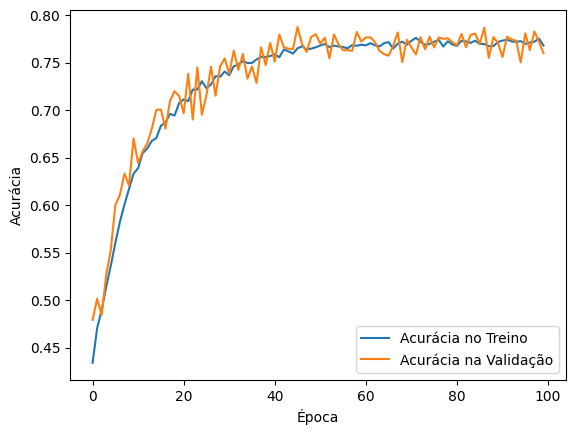

In [48]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Acurácia no conjunto de testes: {test_accuracy:.4f}")

#plot da curva de aprendizado
plt.plot(history.history['accuracy'], label='Acurácia no Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia na Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

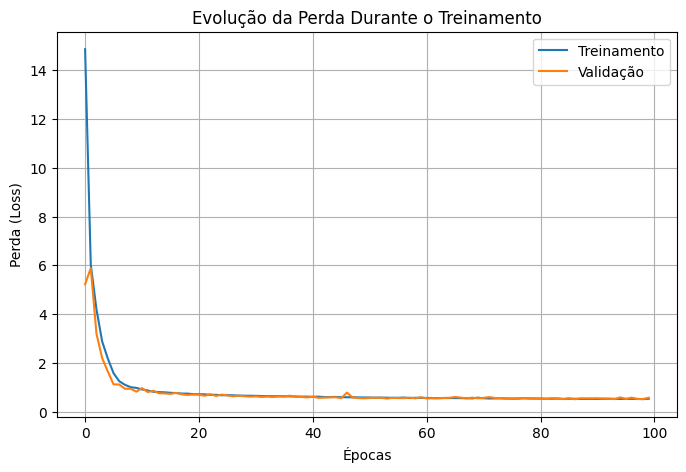

In [49]:
import matplotlib.pyplot as plt

# Plotar a curva de perda
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda (Loss)')
plt.title('Evolução da Perda Durante o Treinamento')
plt.legend()
plt.grid()
plt.show()

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


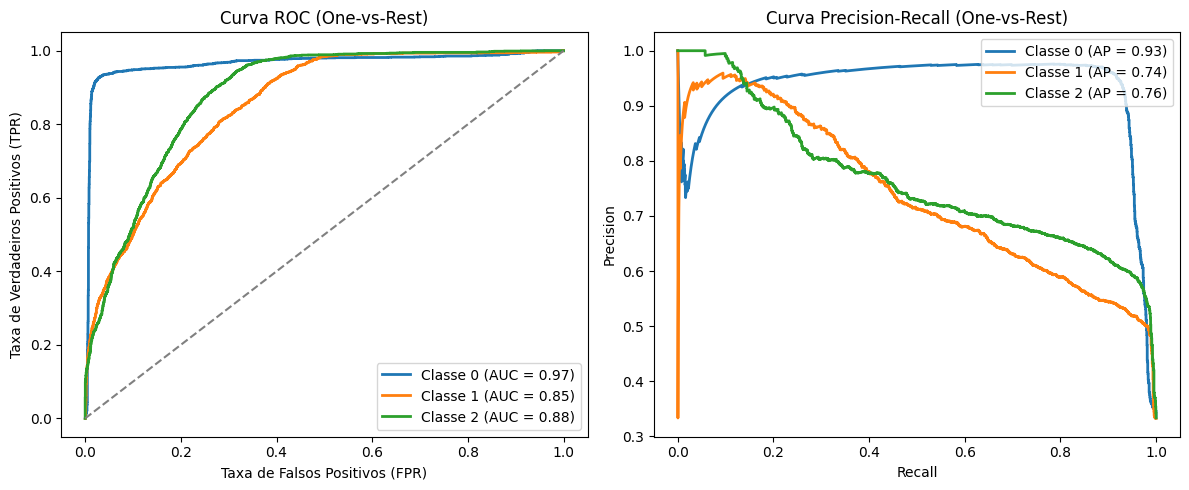

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# 1. Obter as probabilidades previstas para cada classe
y_scores = model.predict(X_test)  # Usar model.predict para obter as probabilidades

# 2. Converter y_test de one-hot para classes únicas (se necessário)
if y_test.ndim == 1:
    # y_test já está no formato de classes únicas
    y_test_classes = y_test
else:
    # Converter y_test de one-hot para classes únicas
    y_test_classes = np.argmax(y_test, axis=1)

# 3. Número de classes
n_classes = y_scores.shape[1]

# 4. Plotar as curvas ROC e Precision-Recall para cada classe
plt.figure(figsize=(12, 5))

# Curva ROC
plt.subplot(1, 2, 1)
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_classes == i, y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Classe {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC (One-vs-Rest)')
plt.legend(loc='lower right')

# Curva Precision-Recall
plt.subplot(1, 2, 2)
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_classes == i, y_scores[:, i])
    average_precision = average_precision_score(y_test_classes == i, y_scores[:, i])
    plt.plot(recall, precision, lw=2, label=f'Classe {i} (AP = {average_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall (One-vs-Rest)')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [51]:
# Nomes das classes
nomes_classes = ['sinal', 'background_1', 'background_2']

# Exemplo de uso
for i, nome in enumerate(nomes_classes):
    print(f"Classe {i}: {nome}")

Classe 0: sinal
Classe 1: background_1
Classe 2: background_2


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


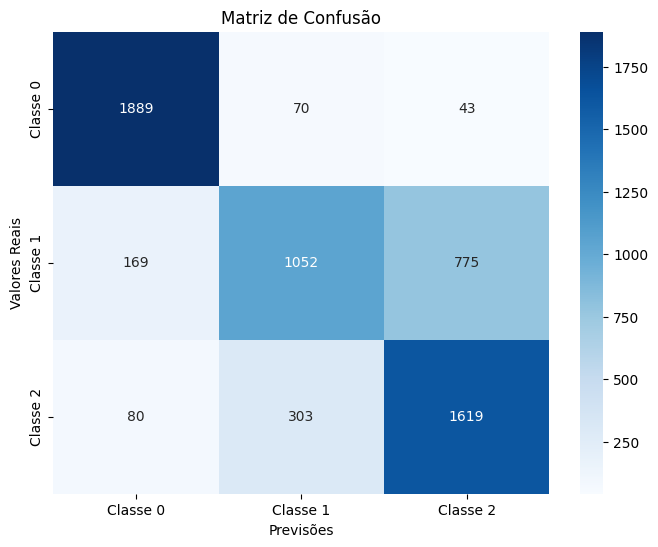

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Obter as previsões do modelo
y_pred = model.predict(X_test)  # Probabilidades para todas as classes
y_pred_classes = np.argmax(y_pred, axis=1)  # Converter probabilidades em classes preditas

# Verificar o formato de y_test
if y_test.ndim == 1:
    # y_test já está no formato de classes únicas
    y_test_classes = y_test
else:
    # Converter y_test de one-hot para classes únicas
    y_test_classes = np.argmax(y_test, axis=1)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Classe 0', 'Classe 1', 'Classe 2'], 
            yticklabels=['Classe 0', 'Classe 1', 'Classe 2'])
plt.xlabel('Previsões')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão')
plt.show()

PermutationExplainer explainer: 6001it [12:18,  8.02it/s]                       
/tmp/ipykernel_4384/2181557943.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=feature_names)


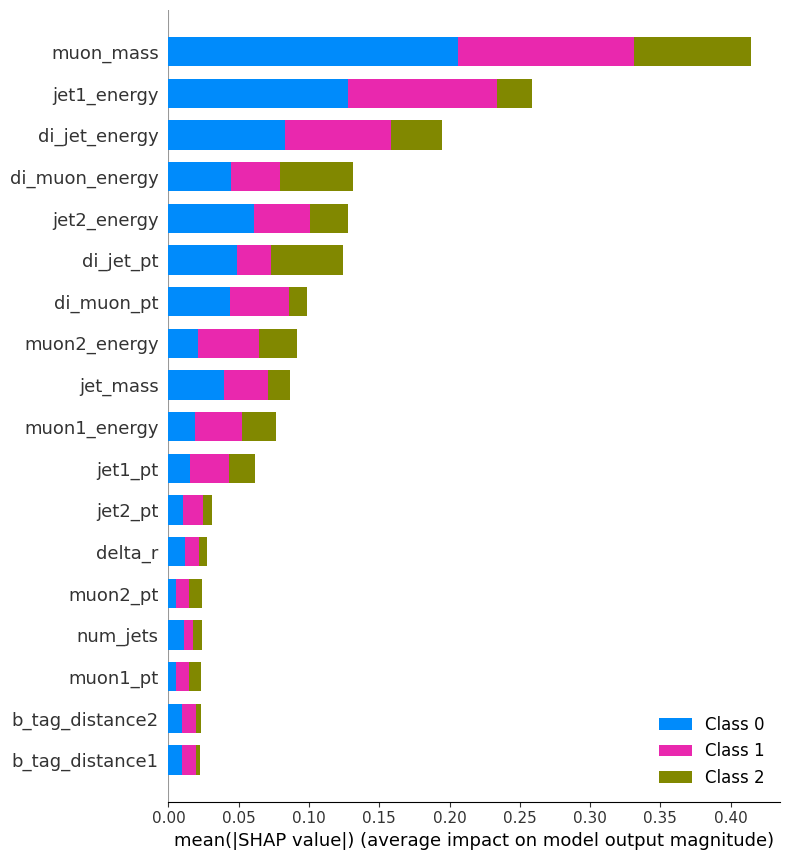

In [53]:
import shap

# Criar um explainer para o modelo
explainer = shap.Explainer(model, X_train)  # X_train é usado como background

# Calcular os valores SHAP para X_test
shap_values = explainer(X_test)

# Nomes das features
feature_names = [
    'muon_mass', 'muon1_pt', 'muon2_pt', 'muon1_energy', 'muon2_energy',
    'di_muon_energy', 'di_muon_pt', 'jet_mass', 'jet1_pt', 'jet2_pt',
    'jet1_energy', 'jet2_energy', 'di_jet_energy', 'di_jet_pt', 'delta_r',
    'num_jets', 'b_tag_distance1', 'b_tag_distance2'
]

# Plotar o summary plot (importância das features)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

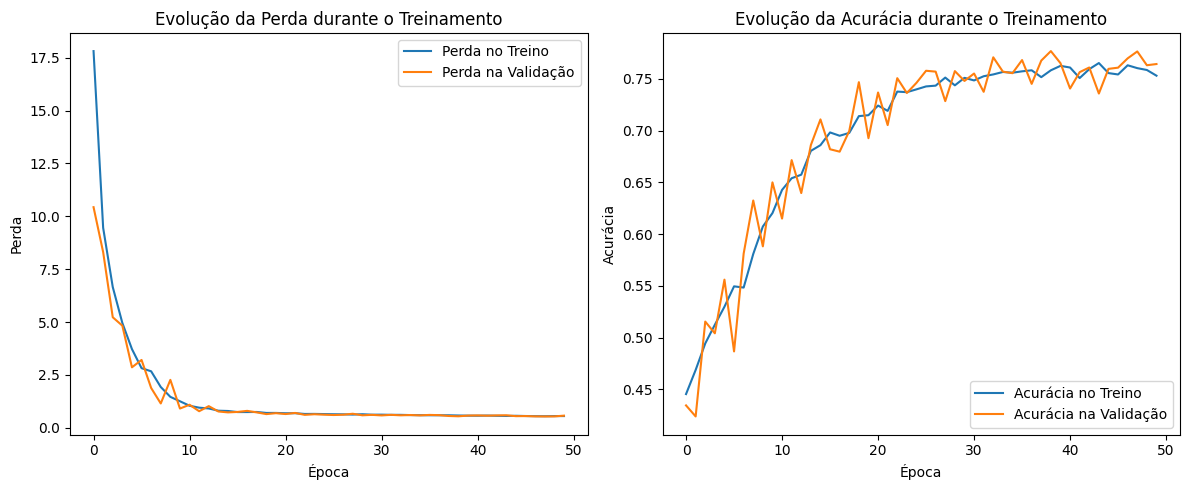

In [27]:
import matplotlib.pyplot as plt

# 1. Plotar a evolução da perda durante o treinamento
plt.figure(figsize=(12, 5))

# Gráfico da perda
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perda no Treino')
plt.plot(history.history['val_loss'], label='Perda na Validação')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.title('Evolução da Perda durante o Treinamento')
plt.legend()

# 2. Plotar a evolução da acurácia durante o treinamento
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Acurácia no Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia na Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.title('Evolução da Acurácia durante o Treinamento')
plt.legend()

plt.tight_layout()
plt.show()
